Rotation with box

In [1]:
import numpy as np
import cv2
from PIL import Image, ImageEnhance
import matplotlib.pyplot as plt
import cv2
import numpy as np
from skimage import io
import os
import PIL
from skimage.filters import threshold_otsu, sobel


In [ ]:
# processing filenames of anomalies
#skip 
folder_path = "/home/clr/Thesis/HoughTransform_xray/Humerus/"
outliers_path = "/home/clr/Thesis/HoughTransform_xray/anomalies/"
image_files = os.listdir(folder_path)
outliers = os.listdir(outliers_path)

#removing ".png.png"
for i, x in enumerate(outliers):
    if ".png.png" in x:
        x = x.replace(".png.png",".png")
        outliers[i] = x
        print(x)

for y in outliers:
    if y in image_files:   
        image_files.remove(y)


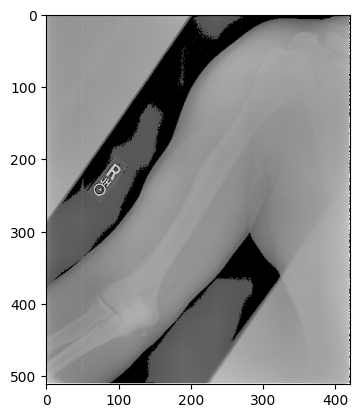

In [116]:
#start of segmentation

image_path = "/home/clr/Thesis/HoughTransform_xray/output_0/MURA-v1.1-train-XR_HUMERUS-patient01245-study1_negative-image1.png"
im_gray = np.array(Image.open(image_path).convert('L'))

#segmentation using thresholding
threshold = threshold_otsu(im_gray)
threshold -= threshold * 0.3
bina_image = im_gray < threshold
inverted_bina_image = np.logical_not(bina_image)

# # Convert the inverted binary image (numpy array) to a Pillow Image object
# inverted_binary_image = Image.fromarray(np.uint8(inverted_bina_image) * 255)
# plt.imshow(inverted_binary_image, cmap='gray')

#removed image background after thresholding
background_removed_image = np.zeros_like(im_gray)
background_removed_image[inverted_bina_image]  = im_gray[inverted_bina_image]
background_removed_image = Image.fromarray(background_removed_image)

plt.imshow(background_removed_image, cmap='gray')

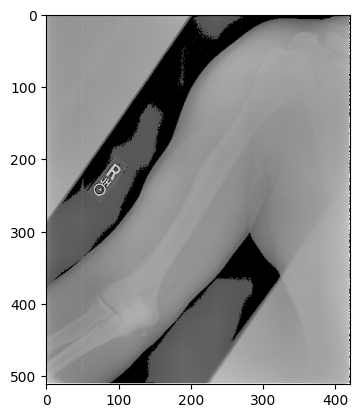

In [112]:
#image brightness enhancer
enhancer = ImageEnhance.Brightness(background_removed_image)

factor = 1
im_output = enhancer.enhance(factor)

plt.imshow(im_output, cmap='gray')

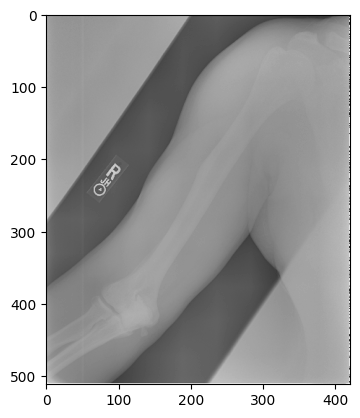

In [113]:
contours, _ = cv2.findContours(np.uint8(im_output), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

best_rect = None
best_rect_area = 0

# Iterate through all contours and find the best fitting rectangle
for contour in contours:
    # Fit a rotated rectangle around the contour
    rect = cv2.minAreaRect(contour)
    box = cv2.boxPoints(rect)
    box_area = rect[1][0] * rect[1][1]

    # Check if the current rectangle has larger area than the previous best
    if box_area > best_rect_area:
        best_rect = box
        best_rect_area = box_area

# Draw the rotated rectangle on the original image
original_image = np.array(im_output)
mask = np.zeros_like(original_image)
cv2.drawContours(mask, [np.int0(best_rect)], 0, (255, 255, 255), cv2.FILLED) # get the rectangl
image_masked = cv2.bitwise_and(original_image, original_image, mask=mask)

#sometimes it cannot detect a rectangle. so we use the original image as mask
if all(element == 255 for row in mask for element in row):
    mask = im_gray

# # Show the final image with the enclosing rotated rectangle
plt.imshow(mask, cmap='gray')
plt.show()

0.0
condition 1


/tmp/ipykernel_137301/2794882146.py:15: RuntimeWarning: invalid value encountered in sqrt
  length = np.sqrt((x2 - x1)^2 + (y2 - y1)^2)


Text(0.5, 1.0, 'Detected Lines')

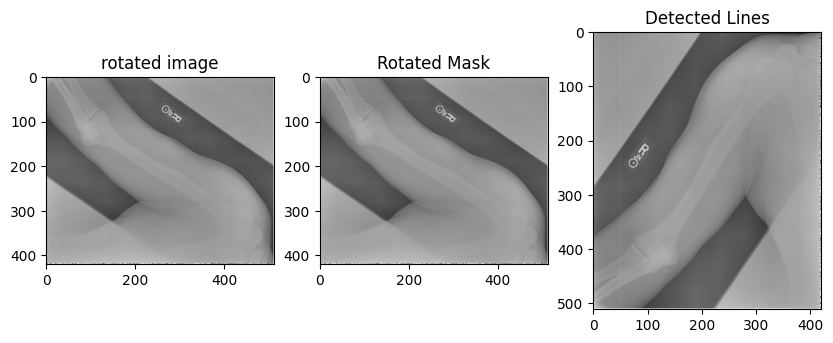

In [114]:
edges = cv2.Canny(mask, 50, 150, apertureSize=3)
lines_list = []

lines = cv2.HoughLinesP(
        edges, # Input edge image
        1, # Distance resolution in pixels
        np.pi/180, # Angle resolution in radians
        threshold=100, # Min number of votes for valid line
        minLineLength=5, # Min allowed length of line
        maxLineGap=5 # Max allowed gap between line for joining them
            )
for points in lines:
    # Extracted points nested in the list
    x1,y1,x2,y2=points[0]
    length = np.sqrt((x2 - x1)^2 + (y2 - y1)^2)
    lines_list.append(length) #get the length of the line 

longest_line = max(lines_list)
longest_line_index = lines_list.index(longest_line)
longest_line = lines[longest_line_index][0] #getting points of the longest line

#compute for the angle of the longest line
angle_radians = np.arctan2(longest_line[3] - longest_line[1], longest_line[2] - longest_line[0])
angle_degrees = np.degrees(angle_radians)

# get width and height of the original image
img_original = cv2.imread(image_path)
# mask_shape = mask.shape[:2]
# print(mask_shape)

height, width = img_original.shape[:2]
center = (width // 2, height // 2)

print(angle_degrees)

# if the image is already upright, will not rotate
# had issues with rotation of angles near to 90 degrees; just included images with angles from 80 to 90
if (angle_degrees <=0.6 and angle_degrees >=0.0):
    print("condition 1")
    rotated_image = np.uint8(im_gray)
    image_masked = cv2.bitwise_and(rotated_image, rotated_image, mask=mask)
    rotated_image = cv2.rotate(image_masked, cv2.ROTATE_90_CLOCKWISE)
    rotated_mask = cv2.rotate(mask, cv2.ROTATE_90_CLOCKWISE)

else:
    if (angle_degrees >= -90 and angle_degrees <= -70) or (angle_degrees <= 90 and angle_degrees >= 70 ) :
        print("condition 2")
        if (angle_degrees <= 90 and angle_degrees >= 70 ):
            print("condition 2.1")
            image_masked = cv2.bitwise_and(im_gray, im_gray, mask=mask)
            rotated_image = cv2.rotate(np.uint8(image_masked), cv2.ROTATE_90_COUNTERCLOCKWISE)
            rotated_mask =cv2.rotate(mask, cv2.ROTATE_90_COUNTERCLOCKWISE)
        elif (angle_degrees >= -90 and angle_degrees <= -70):
            print("condition 2.2")
            image_masked = cv2.bitwise_and(im_gray, im_gray, mask=mask)
            rotated_image = cv2.rotate(np.uint8(image_masked), cv2.ROTATE_90_CLOCKWISE)
            rotated_mask =cv2.rotate(mask, cv2.ROTATE_90_CLOCKWISE)
        
    else:
        #where mask is horizontal but base image is vertical crops image inside
        print("condition 3")
        rotation_matrix = cv2.getRotationMatrix2D(center, angle_degrees, 1) #1 is image zoo,
        #making sure the height is always longer. so image is always vertical 
        if height < width:
            print("condition 3.1")
            image_masked = cv2.bitwise_and(im_gray, im_gray, mask=mask)
            rotated_image = cv2.warpAffine(image_masked, rotation_matrix, (width, height))
            rotated_mask = cv2.warpAffine(mask, rotation_matrix, (width, height))
        else:
            print("condition 3.2")
            im_gray = np.uint8(img_original)
            image_masked = cv2.bitwise_and(im_gray, im_gray, mask=mask)
            rotated_image = cv2.warpAffine(image_masked, rotation_matrix, (height, width))
            rotated_mask = cv2.warpAffine(mask, rotation_matrix, (height, width))

#rotation of whole image (not just the mask)
if angle_degrees < -0.6:
    print("condition 4")
    rotated_image = cv2.rotate(rotated_image, cv2.ROTATE_90_COUNTERCLOCKWISE)
    rotated_mask = cv2.rotate(rotated_mask, cv2.ROTATE_90_COUNTERCLOCKWISE)
elif angle_degrees > 0.6:
    print("condition 5")
    rotated_image = cv2.rotate(rotated_image, cv2.ROTATE_90_CLOCKWISE)
    rotated_mask = cv2.rotate(rotated_mask, cv2.ROTATE_90_CLOCKWISE)


fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(rotated_image, cmap='gray')
ax[0].set_title("rotated image")
ax[1].imshow(rotated_mask, cmap='gray')
ax[1].set_title("Rotated Mask") 
ax[2].imshow(mask, cmap='gray')
ax[2].set_title("Detected Lines")

In [ ]:
folder_path= "/home/clr/Thesis/HoughTransform_xray/output_2/"

image_files = os.listdir(folder_path)
fig, ax = plt.subplots(2, 5, figsize=(15, 5))
ax[0][0].imshow(image_output[0], cmap='gray')
ax[0][0].set_title("rotated")
ax[0][1].imshow(image_output[10], cmap='gray')
ax[0][2].imshow(image_output[40], cmap='gray')
ax[0][3].imshow(image_output[50], cmap='gray')
ax[0][4].imshow(image_output[60], cmap='gray')
ax[1][0].imshow(image_output[70], cmap='gray')
ax[1][1].imshow(image_output[80], cmap='gray')
ax[1][2].imshow(image_output[90], cmap='gray')
ax[1][3].imshow(image_output[100], cmap='gray')
ax[1][4].imshow(image_output[110], cmap='gray')

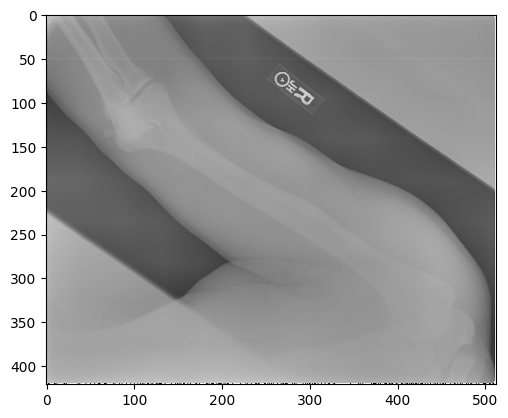

In [115]:
# center image
import numpy
mask_image = numpy.array(rotated_mask)
original_image = numpy.array(rotated_image)

hh, ww = mask_image.shape

# get the contours of the rotated image
contours = cv2.findContours(mask_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = contours[0] if len(contours) == 2 else contours[1]

for cntr in contours:
    x,y,w,h = cv2.boundingRect(cntr)
# recenter

startx = (ww - w)//2
starty = (hh - h)//2
result = np.zeros_like(original_image)
result[starty:starty+h,startx:startx+w] = original_image[y:y+h,x:x+w]

plt.imshow(result, cmap='gray')
plt.show()

Text(0.5, 1.0, 'centered')

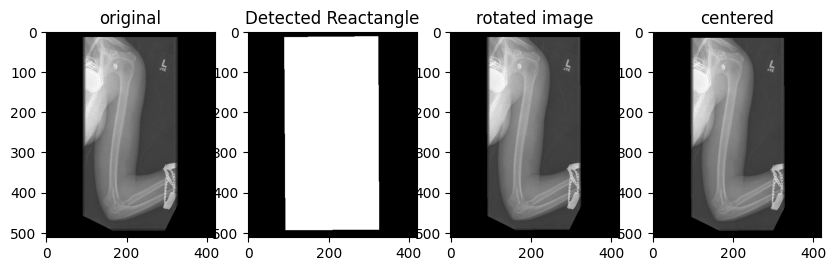

In [110]:
fig, ax = plt.subplots(1, 4, figsize=(10, 5))
ax[0].imshow(im_gray, cmap='gray')
ax[0].set_title("original")
ax[1].imshow(mask, cmap='gray')
ax[1].set_title("Detected Reactangle")
ax[2].imshow(rotated_image, cmap='gray')
ax[2].set_title("rotated image")
ax[3].imshow(result, cmap='gray')
ax[3].set_title("centered")


### Automatic image inversion
checks if there are more black pixels than white, if not will invert images <br>
will not be use in the houghBoxRotate.py anymore

In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2


image_path = "/home/clr/Thesis/HoughTransform_xray/output_images/MURA-v1.1-train-XR_HUMERUS-patient02695-study1_positive-image1.png"
im_gray = np.array(Image.open(image_path).convert('L'))

blackPxNum = np.count_nonzero([im_gray<=100]) #number of black pixels
whitePxNum = im_gray.size - blackPxNum 

if blackPxNum > whitePxNum:
    print("Black")
else:
    print("white")
    im_gray = cv2.bitwise_not(im_gray)


plt.imshow(im_gray , cmap='gray')